Import thư viện

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Load dữ liệu

In [2]:
train_df = pd.read_csv('../Dataset/712/train.csv')
valid_df = pd.read_csv('../Dataset/712/valid.csv')
test_df = pd.read_csv('../Dataset/712/test.csv')

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (31362, 17)
Valid: (4480, 17)
Test: (8962, 17)


Tiền xử lý và tính doanh thu Revenue

In [3]:
def preprocess(df, encoders=None, scaler=None, is_train=True):
    df = df.copy()

    # Tính Revenue
    df['Revenue'] = df['Quantity'] * df['UnitPrice'] * (1 - df['Discount'])

    # Các cột
    categorical_cols = ['Country', 'Category', 'SalesChannel', 'PaymentMethod']
    numerical_cols = ['Quantity', 'UnitPrice', 'Discount', 'ShippingCost']
    target_col = 'Revenue'
    
    # Encode categorical
    if is_train:
        encoders = {col: LabelEncoder().fit(df[col].astype(str)) for col in categorical_cols}
    for col in categorical_cols:
        df[col] = encoders[col].transform(df[col].astype(str))
    
    # Scale numerical
    if is_train:
        scaler = StandardScaler().fit(df[numerical_cols])
    df[numerical_cols] = scaler.transform(df[numerical_cols])
    
    # Features and Target
    X = df[categorical_cols + numerical_cols]
    y = df[target_col] if target_col in df.columns else None
    
    return X, y, encoders, scaler

In [4]:
X_train, y_train, encoders, scaler = preprocess(train_df, is_train=True)
X_valid, y_valid, _, _ = preprocess(valid_df, encoders, scaler, is_train=False)
X_test, _, _, _ = preprocess(test_df, encoders, scaler, is_train=False) 

Dataset và Dataloader 

In [5]:
class SalesDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32) if y is not None else None
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        return self.X[idx]

In [9]:
train_data = SalesDataset(X_train, y_train)
valid_data = SalesDataset(X_valid, y_valid)
test_data = SalesDataset(X_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

Mô hình transformer đơn giản

In [10]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        self.embedding = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # (batch, seq_len=1, dim)
        x = self.transformer_encoder(x)
        out = self.fc(x[:, 0])
        return out.squeeze(1)

Huấn luyện mô hình 

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(input_dim=X_train.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def evaluate(model, loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds.append(outputs.cpu().numpy())
            targets.append(y.cpu().numpy())
    return np.concatenate(preds), np.concatenate(targets)

# Train loop
for epoch in range(20):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
    
    val_preds, val_true = evaluate(model, valid_loader)
    val_mae = mean_absolute_error(val_true, val_preds)
    val_mse = mean_squared_error(val_true, val_preds)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(val_true, val_preds)
    print(f"Epoch {epoch+1} - Val MAE: {val_mae:.2f}, Val MSE: {val_mse:.2f}, Val RMSE: {val_rmse:.2f}, Val R²: {val_r2:.2f}")

c:\Users\Tran Thi Kieu Oanh\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1 - Val MAE: 859.01, Val MSE: 1470811.00, Val RMSE: 1212.77, Val R²: -0.96
Epoch 2 - Val MAE: 713.31, Val MSE: 1156123.38, Val RMSE: 1075.23, Val R²: -0.54
Epoch 3 - Val MAE: 537.53, Val MSE: 822567.12, Val RMSE: 906.95, Val R²: -0.09
Epoch 4 - Val MAE: 392.26, Val MSE: 548558.31, Val RMSE: 740.65, Val R²: 0.27
Epoch 5 - Val MAE: 303.15, Val MSE: 355413.97, Val RMSE: 596.17, Val R²: 0.53
Epoch 6 - Val MAE: 224.58, Val MSE: 227713.72, Val RMSE: 477.19, Val R²: 0.70
Epoch 7 - Val MAE: 156.81, Val MSE: 140664.72, Val RMSE: 375.05, Val R²: 0.81
Epoch 8 - Val MAE: 102.29, Val MSE: 86970.71, Val RMSE: 294.91, Val R²: 0.88
Epoch 9 - Val MAE: 113.99, Val MSE: 60813.21, Val RMSE: 246.60, Val R²: 0.92
Epoch 10 - Val MAE: 99.94, Val MSE: 38604.02, Val RMSE: 196.48, Val R²: 0.95
Epoch 11 - Val MAE: 73.41, Val MSE: 24091.42, Val RMSE: 155.21, Val R²: 0.97
Epoch 12 - Val MAE: 44.00, Val MSE: 14244.67, Val RMSE: 119.35, Val R²: 0.98
Epoch 13 - Val MAE: 32.71, Val MSE: 8852.83, Val RMSE: 94.09, 

Dự đoán trên tập test 

In [12]:
model.eval()
test_preds = []
with torch.no_grad():
    for X in test_loader:
        X = X.to(device)
        outputs = model(X)
        test_preds.append(outputs.cpu().numpy())

test_preds = np.concatenate(test_preds)

Đánh giá hiệu suất trên bộ dữ liệu kiểm tra test

In [14]:
# Tính lại cột 'Revenue' cho test_df 
test_df['Revenue'] = test_df['Quantity'] * test_df['UnitPrice'] * (1 - test_df['Discount'])

test_true = test_df['Revenue'].values 
test_mae = mean_absolute_error(test_true, test_preds)
test_mse = mean_squared_error(test_true, test_preds)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(test_true, test_preds)
print(f"Test MAE: {test_mae:.2f}, Test MSE: {test_mse:.2f}, Test RMSE: {test_rmse:.2f}, Test R²: {test_r2:.2f}")

Test MAE: 44.92, Test MSE: 3249.26, Test RMSE: 57.00, Test R²: 1.00


Hiển thị kết quả 

Text(0.5, 1.0, 'Giá trị thực so với Giá trị dự đoán')

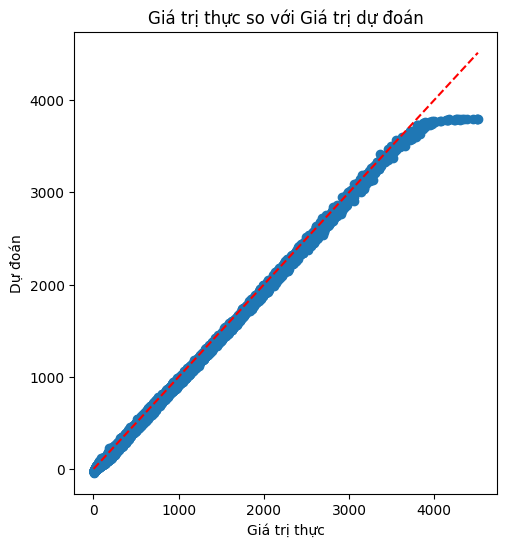

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(test_true, test_preds)
plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], color='red', linestyle='--')
plt.xlabel('Giá trị thực')
plt.ylabel('Dự đoán')
plt.title('Giá trị thực so với Giá trị dự đoán')

Biểu đồ phân phối sai số

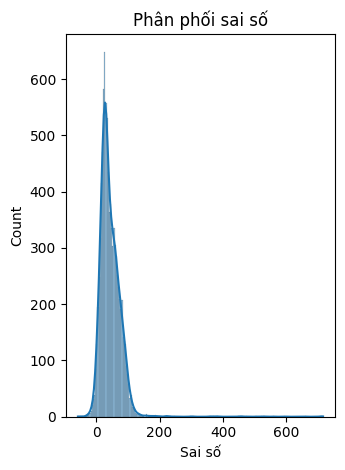

In [16]:
plt.subplot(1, 2, 2)
residuals = test_true - test_preds
sns.histplot(residuals, kde=True)
plt.xlabel('Sai số')
plt.title('Phân phối sai số')

plt.tight_layout()
plt.show()

Doanh thu ngày 2024-07-14: Thực tế = 5555.79, Dự đoán = 5101.97
Doanh thu ngày 2024-07-15: Thực tế = 17284.46, Dự đoán = 16524.78
Doanh thu ngày 2024-07-16: Thực tế = 17465.11, Dự đoán = 16743.84
Doanh thu ngày 2024-07-17: Thực tế = 18793.60, Dự đoán = 17894.53
Doanh thu ngày 2024-07-18: Thực tế = 17826.91, Dự đoán = 17022.18
Doanh thu ngày 2024-07-19: Thực tế = 21833.84, Dự đoán = 20570.50
Doanh thu ngày 2024-07-20: Thực tế = 22494.09, Dự đoán = 21500.44
Doanh thu ngày 2024-07-21: Thực tế = 26006.19, Dự đoán = 24854.46
Doanh thu ngày 2024-07-22: Thực tế = 16874.65, Dự đoán = 15953.18
Doanh thu ngày 2024-07-23: Thực tế = 33938.36, Dự đoán = 32305.63
Doanh thu ngày 2024-07-24: Thực tế = 23208.85, Dự đoán = 21976.99
Doanh thu ngày 2024-07-25: Thực tế = 21291.44, Dự đoán = 20305.28
Doanh thu ngày 2024-07-26: Thực tế = 18288.27, Dự đoán = 17530.68
Doanh thu ngày 2024-07-27: Thực tế = 21034.51, Dự đoán = 20149.60
Doanh thu ngày 2024-07-28: Thực tế = 26938.66, Dự đoán = 25836.66
Doanh thu ng

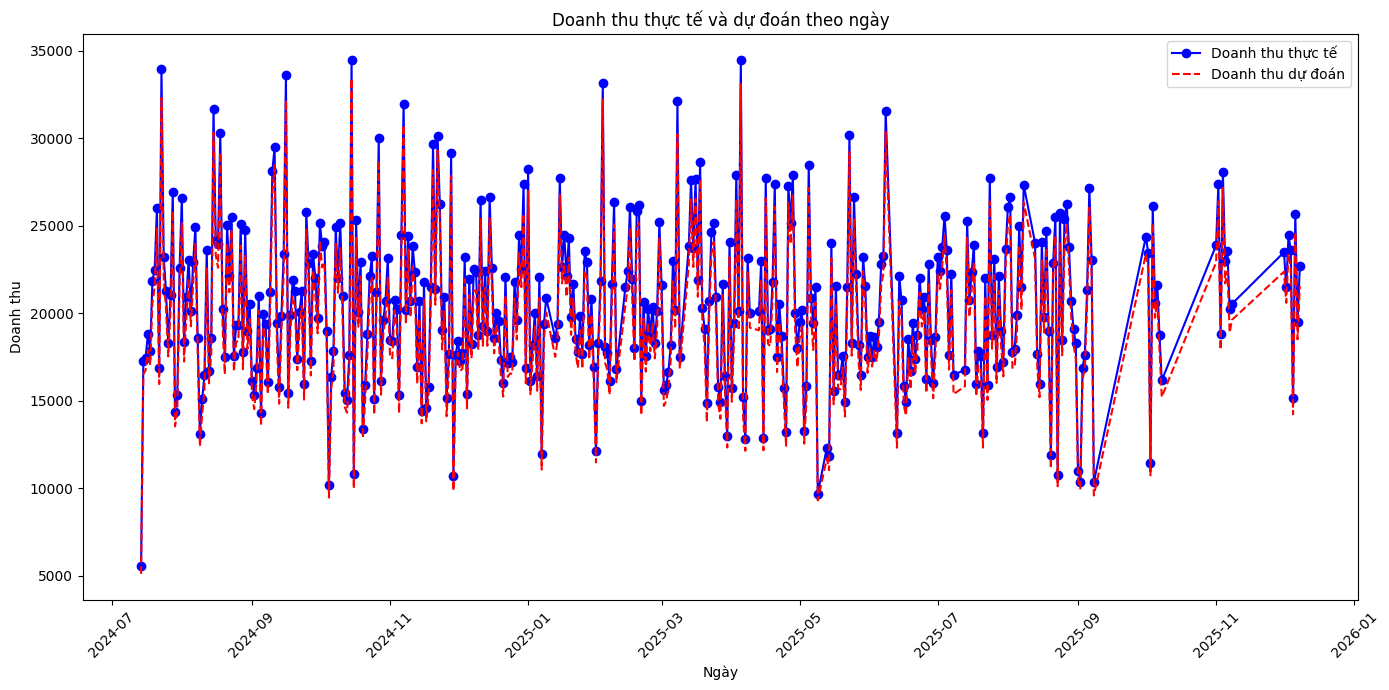

In [23]:
# Chắc chắn rằng cột InvoiceDate có kiểu dữ liệu datetime
if 'InvoiceDate' in test_df.columns:
    test_df['InvoiceDate'] = pd.to_datetime(test_df['InvoiceDate'])
    
    # Dự đoán doanh thu từ mô hình
    test_df['PredictedRevenue'] = test_preds
    
    # Nhóm dữ liệu theo ngày
    daily_sales = test_df.groupby(test_df['InvoiceDate'].dt.date).agg({'Revenue': 'sum', 'PredictedRevenue': 'sum'}).reset_index()

    # In ra doanh thu thực tế và dự đoán theo ngày
    for idx, row in daily_sales.iterrows():
        print(f"Doanh thu ngày {row['InvoiceDate']}: Thực tế = {row['Revenue']:.2f}, Dự đoán = {row['PredictedRevenue']:.2f}")

    # Vẽ đồ thị doanh thu thực tế và dự đoán theo ngày
    plt.figure(figsize=(14, 7))
    plt.plot(daily_sales['InvoiceDate'], daily_sales['Revenue'], label='Doanh thu thực tế', color='blue', marker='o')
    plt.plot(daily_sales['InvoiceDate'], daily_sales['PredictedRevenue'], label='Doanh thu dự đoán', color='red', linestyle='--')
    plt.xlabel('Ngày')
    plt.ylabel('Doanh thu')
    plt.title('Doanh thu thực tế và dự đoán theo ngày')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()